## Import 

d2l==0.16.1

In [1]:
from d2l import torch as d2l
import torch
from torch import nn


## Generate some "real" data

Since this is going to be the world's lamest example, we simply generate data drawn from a Gaussian.


In [2]:
X = torch.normal(0.0,1, size=(1000, 2))
A = torch.tensor([[1,2],[-0.1,0.5]])
b = torch.tensor([1,2])
data = torch.matmul(X,A) + b #element-wise sum

Let us see what we got. This should be a Gaussian shifted in some rather arbitrary way with mean $b$ and covariance matrix $A^TA$.


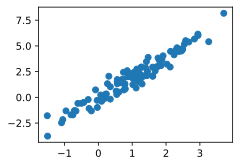

In [3]:
d2l.set_figsize()
d2l.plt.scatter(data[:100,0].detach().numpy(), data[:100,1].detach().numpy())

In [4]:
batch_size = 8 
data_iter = d2l.load_array((data,), batch_size)


## Generator

Our generator network will be the simplest network possible - a single layer linear model. This is since we will be driving that linear network with a Gaussian data generator. Hence, it literally only needs to learn the parameters to fake things perfectly.


In [5]:
net_G = nn.Sequential(nn.Linear(2,2))

## Discriminator

For the discriminator we will be a bit more discriminating: we will use an MLP with 3 layers to make things a bit more interesting.


In [6]:
net_D = nn.Sequential(nn.Linear(2, 5), nn.Tanh(), nn.Linear(5, 3), nn.Tanh(), nn.Linear(3,1)
)

## Training

First we define a function to update the discriminator.


In [7]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):

    batch_size = X.shape[0] # 1000
    ones = torch.ones((batch_size,), device = X.device)
    zeros = torch.zeros((batch_size,), device = X.device)

    trainer_D.zero_grad() # backward 계산을 위해서 변화도를 0으로 set
    real_Y = net_D(X)
    fake_X = net_G(Z)

    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape))+loss(fake_Y,zeros.reshape(fake_Y.shape)))/2
    loss_D.backward()
    trainer_D.step()
    return loss_D


The generator is updated similarly. Here we reuse the cross-entropy loss but change the label of the fake data from $0$ to $1$.


In [8]:
def update_G(Z, net_D, net_G, loss, trainer_G):

    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device= Z.device)
    
    trainer_G.zero_grad()
    
    fake_X = net_G(Z)
    fake_Y = net_D(fake_X)

    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))

    loss_G.backward()
    trainer_G.step()
    return loss_G

Both the discriminator and the generator performs a binary logistic regression with the cross-entropy loss. We use Adam to smooth the training process. In each iteration, we first update the discriminator and then the generator. We visualize both losses and generated examples.


In [9]:
def Train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):

    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs], nrows=2, figsize=(5,5), legend = ['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(num_epochs):

        timer = d2l.Timer()
        metric = d2l.Accumulator(3)

        for(X,) in data_iter :
            batch_size = X.shape[0]
            Z = torch.normal(0,1, size=(batch_size, latent_dim))

            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D), update_G(Z, net_D,net_G, loss, trainer_G), batch_size)

        Z = torch.normal(0,1,size=(100,latent_dim))
        fake_X = net_G(Z).detach().numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])

        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch+1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, 'f'{metric[2]/timer.stop():0.1f} examples/sec')

Now we specify the hyperparameters to fit the Gaussian distribution.


loss_D 0.693, loss_G 0.693, 1596.2 examples/sec


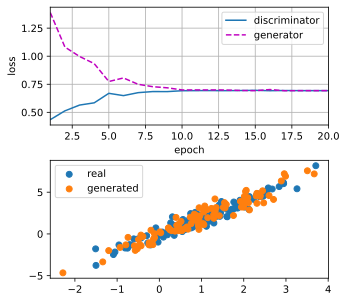

In [12]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
Train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data[:100].detach().numpy())